In [1]:
import sys
sys.path.insert(0, '..')

%load_ext tools.prov_magics
import tools.view.intertwined_prov
from tools.query.intertwined_prov import *

In [2]:
def wdf_text(e2, e1, a, attrs):
    return querier.text("wasDerivedFrom", [e2, e1, a], attrs=dict(attrs), id_=None)

def get_original_reference(ref, result=None):
    A, D, AT, TX = var(4)
    if result is None:
        result = set()
    first = False
    while not first:
        first = True
        query = [
            (A.bound, D.bound, TX.bound, AT.bound) 
            for __ in (
                wasDerivedFrom(ref, D, A, type="intertwined:Reference", attrs=AT)
                & entity(D, text=TX)
            )]
        if query:
            act, ent, text, attrs = query[0]
            result.add(text)
            result.add(wdf_text(ref, ent, act, attrs))
            first = False
            ref = ent
    return ref, result

In [3]:
import datetime
from collections import namedtuple, deque
from copy import copy
from pprint import pprint

Context = namedtuple("Context", "type to_parts checkpoint")

def neighborhood(context):
    n, move_to_parts, time = context
    
    temp_time = datetime.datetime.max
    
    _ = BLANK
    A, C, D, T, TP, U, W, AT, TX, TX2, TX3 = var("A C D T TP U W AT TX TX2 TX3")
    
    # Follow default derivations
    query = (
        wasDerivedFrom(n, D, A, _, _, type=TP, checkpoint=T, collection=W, attrs=AT)
        & entity(D, _, _, TX)
    )
    for __ in query:
        if TP.bound == "intertwined:Reference":
            temp_time = min(temp_time, T.bound)
            yield Context(D.bound, move_to_parts, None), {TX.bound, wdf_text(n, D.bound, A.bound, AT.bound)}
        else:
            yield Context(D.bound, True, None), {TX.bound, wdf_text(n, D.bound, A.bound, AT.bound)}
        # Move to collection
        if W.bound:
            for __ in entity(W.bound, _, _, TX2):
                yield Context(W.bound, False, T.bound), {wdf_text(n, D.bound, A.bound, AT.bound), TX2.bound}
    
    if move_to_parts:
        # Get initial reference to value
        original, result = get_original_reference(n)

        # Use reference time if time is not defined
        if not time:
            time = temp_time
        
        # Move to all parts of the structure 
        # Sort generatedAtTime of version entities
        query = (
            specializationOf(original, A, TX)
            & entity(A, T, "intertwined:Version", TX2)
        )
        version = max(
            (T.bound, A.bound, TX.bound, TX2.bound)
            for __ in query
            if T.bound <= time
        )
        result.add(version[2])
        result.add(version[3])
        
        stack = deque([(version[1], {version[2], version[3]})])
        # Reconstruct state
        state = {}
        while stack:
            cur_ver, text = stack.pop()
            query = (
                derivedByInsertionFrom(cur_ver, D, C, TX)
                & entity(D, _, _, TX2)
            )
            for __ in query:
                stack.appendleft((D.bound, text | {TX.bound, TX2.bound}))
                for key, value in C.bound:
                    if key not in state:
                        for __ in entity(value, _, _, TX3):
                            state[key] = (value, text | {TX.bound, TX2.bound, TX3.bound})

            
            query = (
                hadDictionaryMember(cur_ver, D, U, TX)
                & entity(D, _, _, TX2)
            )
            for __ in query:
                key = U.bound
                value = D.bound
                if key not in state:
                    state[key] = (value, text | {TX.bound, TX2.bound})
        
        # Move to parts of the state
        for value, text in state.values():
            yield (Context(value, True, time), result | text)

def dfs(ent, neigh):
    context = Context(ent, True, None)
    stack = [context]
    visited = set()
    TX = var("text")
    result = {TX.bound for __ in entity(ent, BLANK, BLANK, TX)} 
    while stack:
        context = stack.pop()
        for other, tresult in neigh(context):
            if other not in visited:
                visited.add(other)
                result |= tresult
                stack.append(other)
                
    return result

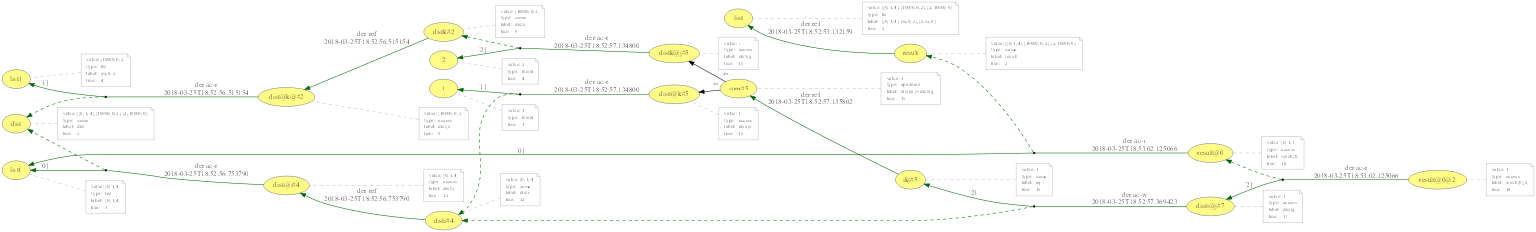

In [4]:
querier.load("../generated/intertwined_prov/floydwarshall.provn");
view = "provn png svg pdf"
get_ipython().run_cell_magic(
    "provn",
    "-o {} -e {} -r RL".format("../generated/intertwined_prov/query", view),
    '\n'.join(dfs("result@0@2", neighborhood))
)